In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:
data = pd.read_csv('ex2data2.txt', sep=",", header=None,names=["Test-1", "Test-2","Accept Microchip"])
print(data)

       Test-1    Test-2  Accept Microchip
0    0.051267  0.699550                 1
1   -0.092742  0.684940                 1
2   -0.213710  0.692250                 1
3   -0.375000  0.502190                 1
4   -0.513250  0.465640                 1
..        ...       ...               ...
113 -0.720620  0.538740                 0
114 -0.593890  0.494880                 0
115 -0.484450  0.999270                 0
116 -0.006336  0.999270                 0
117  0.632650 -0.030612                 0

[118 rows x 3 columns]


In [3]:
def plotDecisionBoundary(theta,degree, axes):
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    U,V = np.meshgrid(u,v)
    # convert U, V to vectors 
    U = np.ravel(U)
    V = np.ravel(V)
    Z = np.zeros((len(u) * len(v)))
    
    X_poly = mapFeature(U, V, degree)
    Z = X_poly.dot(theta)
    
    # reshape U, V, Z back to matrix
    U = U.reshape((len(u), len(v)))
    V = V.reshape((len(u), len(v)))
    Z = Z.reshape((len(u), len(v)))
    
    cs = axes.contour(U,V,Z,levels=[0])
    axes.legend(labels=['Accepted', 'Rejected', 'Decision Boundary'])
    return cs
def mapFeature(X1, X2, degree):
    res = np.ones(X1.shape[0])
    for i in range(1,degree + 1):
        for j in range(0,i + 1):
            res = np.column_stack((res, (X1 ** (i-j)) * (X2 ** j)))
    
    return res

Text(0, 0.5, 'Test 2 Score')

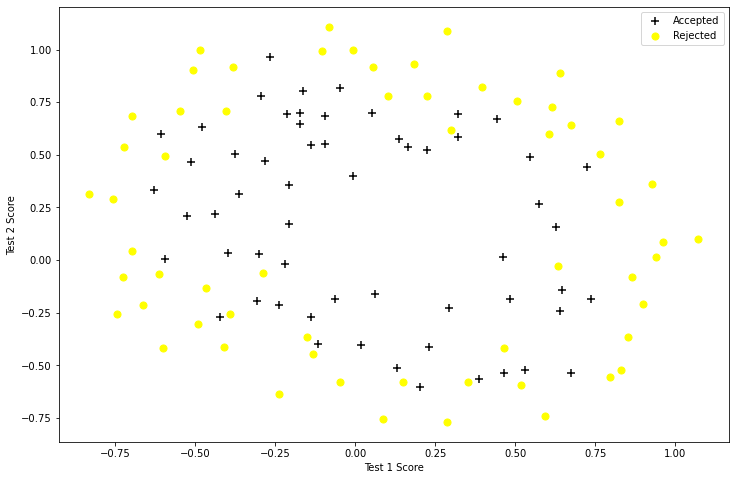

In [4]:
positiveClass = data[data['Accept Microchip'].isin([1])]
negativeClass = data[data['Accept Microchip'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positiveClass['Test-1'], positiveClass['Test-2'], s=50, c='black', marker='+', label='Accepted')
ax.scatter(negativeClass['Test-1'], negativeClass['Test-2'], s=50, c='yellow', marker='o', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

In [5]:
degree = 6
x1 = data['Test-1']
x2 = data['Test-2']
#dummy feature
data.insert(3, 'Ones', 1)

for i in range(1, degree+1):
    for j in range(0, i+1):
        data['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data.drop('Test-1', axis=1, inplace=True)
data.drop('Test-2', axis=1, inplace=True)

data.head()

,Accept Microchip,Ones,F10,F11,F20,F21,F22,F30,F31,F32,...,F53,F54,F55,F60,F61,F62,F63,F64,F65,F66
0,1,1,0.051267,0.69955,0.002628,0.035864,0.489370,0.000135,0.001839,0.025089,...,0.000900,0.012278,0.167530,1.815630e-08,2.477469e-07,0.000003,0.000046,0.000629,0.008589,0.117196
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [6]:
def RegularizedCost(theta, X, Y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    Y = np.matrix(Y)
    
    term1 = np.multiply(-Y, np.log(sigmoidFunction(X * theta.T))) #-y * log(h(x))
    term2 = np.multiply((1 - Y), np.log(1 - sigmoidFunction(X * theta.T))) #(1-y)*log(1-h(x))
    
    regFactor = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2)) 
    
    return np.sum(term1 - term2) / (len(X)) + regFactor

In [7]:
def RegularizedGradient(theta, X, Y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    Y = np.matrix(Y)
    
    featureCount = int(theta.ravel().shape[1])
    gradient = np.zeros(featureCount)
    
    error = sigmoidFunction(X * theta.T) - Y
    
    for i in range(featureCount):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            gradient[i] = np.sum(term) / len(X)# j=0
        else:
            gradient[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])# j=1 learningRate/size of X *theta[i]
    
    return gradient
def sigmoidFunction(z):
    return 1 / (1 + np.exp(-z))

In [8]:
cols = data.shape[1]
X2=data.iloc[:,1:cols]
y2=data.iloc[:,0:1]
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta0 = np.zeros(28)

In [9]:
learningRate = 1

In [10]:
RegularizedCost(theta0, X2, y2, learningRate)

0.6931471805599454

In [11]:
RegularizedGradient(theta0, X2, y2, learningRate)

array([8.47457627e-03, 1.87880932e-02, 7.78135593e-05, 5.03446395e-02,
       1.15013330e-02, 3.76649066e-02, 1.83559872e-02, 7.32393402e-03,
       8.19244772e-03, 2.34765511e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600505e-02, 3.09594039e-03, 3.93028751e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643903e-03, 5.83822094e-03, 4.47629364e-03,
       3.10080356e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503014e-04, 7.26504332e-03, 1.37646435e-03, 3.87936789e-02])

In [12]:
result0 = opt.fmin_tnc(func=RegularizedCost, x0=theta0, fprime=RegularizedGradient, args=(X2, y2, learningRate))
result0

(array([ 2.49641262e-04,  1.37411881e-04,  2.77014857e-04, -4.35864780e-04,
        -1.62450154e-04, -2.48691187e-04,  3.40751509e-05, -7.16774229e-05,
        -7.34925368e-05, -2.03235205e-05, -3.10561784e-04, -1.49841005e-05,
        -1.31827706e-04, -4.36572110e-05, -2.29977995e-04, -3.43132227e-05,
        -4.33025391e-05, -1.87924827e-05, -5.59545724e-05, -5.21235877e-05,
        -9.08327640e-05, -2.10980599e-04,  2.17301660e-06, -6.54199924e-05,
        -8.84462763e-07, -6.91290878e-05, -1.78752463e-05, -1.85528124e-04]),
 98,
 4)

In [13]:
updatedtheta0=result0[0]
print(updatedtheta0)

[ 2.49641262e-04  1.37411881e-04  2.77014857e-04 -4.35864780e-04
 -1.62450154e-04 -2.48691187e-04  3.40751509e-05 -7.16774229e-05
 -7.34925368e-05 -2.03235205e-05 -3.10561784e-04 -1.49841005e-05
 -1.31827706e-04 -4.36572110e-05 -2.29977995e-04 -3.43132227e-05
 -4.33025391e-05 -1.87924827e-05 -5.59545724e-05 -5.21235877e-05
 -9.08327640e-05 -2.10980599e-04  2.17301660e-06 -6.54199924e-05
 -8.84462763e-07 -6.91290878e-05 -1.78752463e-05 -1.85528124e-04]


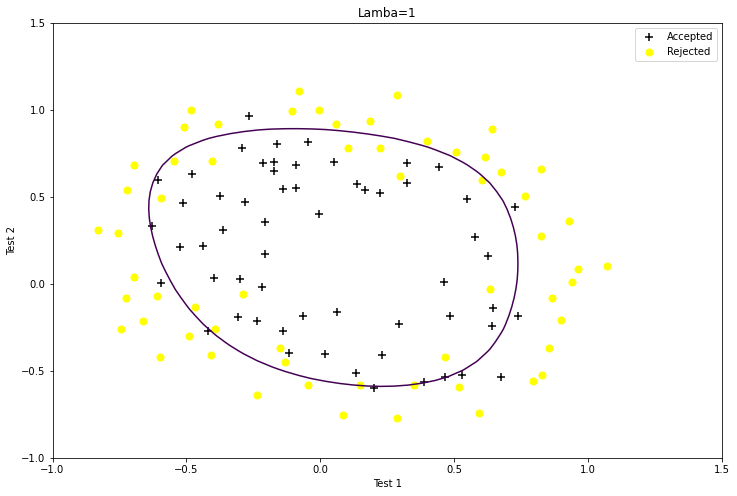

In [14]:
positiveClass = data[data['Accept Microchip'].isin([1])]
negativeClass = data[data['Accept Microchip'].isin([0])]
fig, ax = plt.subplots(figsize=(12,8));
ax.set_xlabel('Test 1')
ax.set_ylabel('Test 2')
ax.scatter(positiveClass['F10'], positiveClass['F11'], s=50, c='black', marker='+', label='Accepted')
ax.scatter(negativeClass['F10'], negativeClass['F11'], s=50, c='yellow', marker='o', label='Rejected')
plt.title("Lamba=1")
plotDecisionBoundary(updatedtheta0, 6, ax)

In [15]:
learningRate = 0

In [16]:
result1 = opt.fmin_tnc(func=RegularizedCost, x0=updatedtheta0, fprime=RegularizedGradient, args=(X2, y2, learningRate))
result1

(array([   9.80772029,   13.33854843,    6.05553715, -100.54470799,
         -62.91927813,  -29.96279513, -114.94135774, -103.37066731,
         -37.79684543,    1.36549323,  376.98002191,  381.56473406,
         370.39944766,  175.51958932,   22.3642478 ,  216.93552695,
         349.94828879,  359.74122842,  166.34057557,   24.21486376,
           3.07550368, -463.94398831, -680.98634555, -881.02120737,
        -670.7974377 , -451.63132094, -168.01627112,  -19.17556842]),
 281,
 3)

In [17]:
updatedtheta0=result1[0]
print(updatedtheta0)

[   9.80772029   13.33854843    6.05553715 -100.54470799  -62.91927813
  -29.96279513 -114.94135774 -103.37066731  -37.79684543    1.36549323
  376.98002191  381.56473406  370.39944766  175.51958932   22.3642478
  216.93552695  349.94828879  359.74122842  166.34057557   24.21486376
    3.07550368 -463.94398831 -680.98634555 -881.02120737 -670.7974377
 -451.63132094 -168.01627112  -19.17556842]


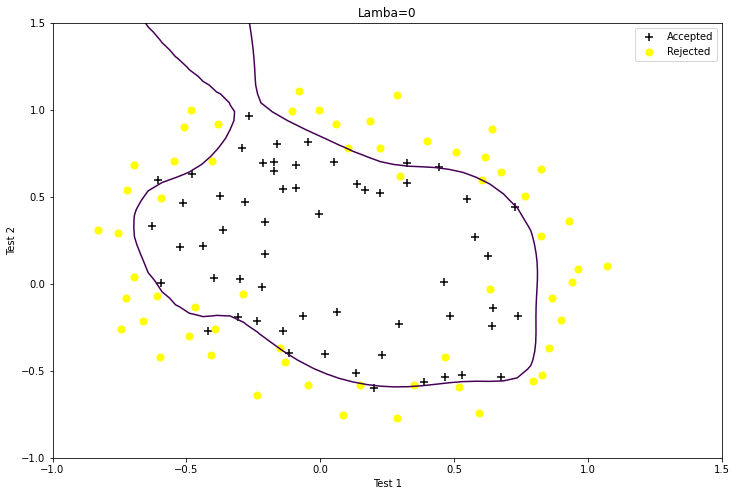

In [18]:
fig, ax = plt.subplots(figsize=(12,8));
ax.set_xlabel('Test 1')
ax.set_ylabel('Test 2')
ax.scatter(positiveClass['F10'], positiveClass['F11'], s=50, c='black', marker='+', label='Accepted')
ax.scatter(negativeClass['F10'], negativeClass['F11'], s=50, c='yellow', marker='o', label='Rejected')
plt.title("Lamba=0")
plotDecisionBoundary(updatedtheta0, 6, ax)

In [19]:
learningRate = 100
theta1=np.zeros(28)

In [20]:
result2 = opt.fmin_tnc(func=RegularizedCost, x0=theta1, fprime=RegularizedGradient, args=(X2, y2, learningRate))
result2

(array([ 2.80291588e-07, -2.05609598e-06,  1.19522144e-06, -6.63748155e-06,
        -1.70320432e-06, -4.35587732e-06, -2.21189099e-06, -9.15884996e-07,
        -1.10594263e-06, -2.56285471e-06, -5.33382836e-06, -2.99639836e-07,
        -1.71675981e-06, -4.57305249e-07, -4.92173500e-06, -2.56391940e-06,
        -5.75500869e-07, -4.37902147e-07, -7.65808900e-07, -6.32966179e-07,
        -3.79087951e-06, -4.21777923e-06, -1.32363057e-07, -8.63375656e-07,
        -4.84926404e-08, -9.74377888e-07, -2.04809054e-07, -4.94729350e-06]),
 88,
 4)

In [21]:
updatedtheta0=result2[0]
print(updatedtheta0)

[ 2.80291588e-07 -2.05609598e-06  1.19522144e-06 -6.63748155e-06
 -1.70320432e-06 -4.35587732e-06 -2.21189099e-06 -9.15884996e-07
 -1.10594263e-06 -2.56285471e-06 -5.33382836e-06 -2.99639836e-07
 -1.71675981e-06 -4.57305249e-07 -4.92173500e-06 -2.56391940e-06
 -5.75500869e-07 -4.37902147e-07 -7.65808900e-07 -6.32966179e-07
 -3.79087951e-06 -4.21777923e-06 -1.32363057e-07 -8.63375656e-07
 -4.84926404e-08 -9.74377888e-07 -2.04809054e-07 -4.94729350e-06]


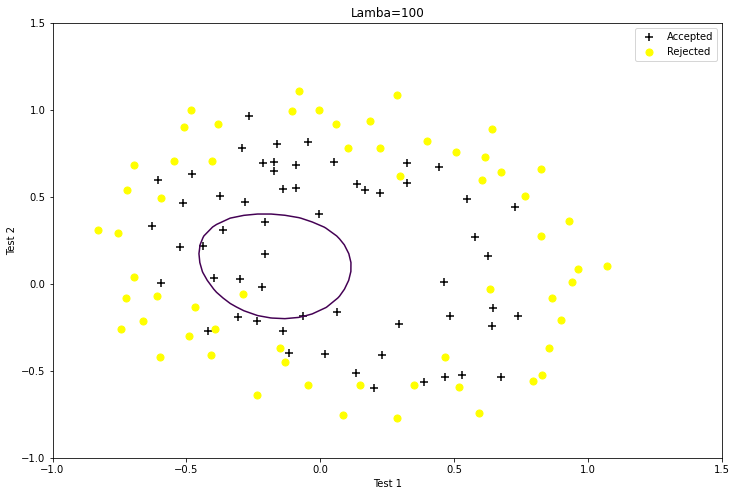

In [22]:
fig, ax = plt.subplots(figsize=(12,8));
ax.set_xlabel('Test 1')
ax.set_ylabel('Test 2')
ax.scatter(positiveClass['F10'], positiveClass['F11'], s=50, c='black', marker='+', label='Accepted')
ax.scatter(negativeClass['F10'], negativeClass['F11'], s=50, c='yellow', marker='o', label='Rejected')
plt.title("Lamba=100")
plotDecisionBoundary(updatedtheta0, 6, ax)